# Polybaric liquid-line-of-descents

- One of the primary uses of the MELTS models is simulating the crystallisation of magma under different conditions.
- Users may wish to simulate the crystallization of magma over a range of pressure. PetThermoTools offers two options for these calculations: (i) 'one-step', pressure changes from A to B at a specified temperature; (ii) 'path', a P-T path is defined by the user for the calculation.
- Here we examine how a P-T path can be used to produce polybaric fractional crystallization paths.

**Before any calculations can be run** users need to download the alphaMELTS for MATLAB files. Please see the installation guide on ReadTheDocs.

Data used in the calculations below can be downloaded from here: https://github.com/gleesonm1/PetThermoTools/blob/master/docs/Examples/CrystallisationTests/Fernandina_glass.xlsx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import petthermotools as ptt

# If the alphaMELTS for Python files have not been added to your Python path (see installation guide) then use the two lines below to add
# the location of the alphaMELTS files here.
# import sys
# sys.path.append(r"MELTS")

In [3]:
# Can be used to suppress outputs on MacOS - run twice
import platform
if platform.system() == "Darwin":
    import sys
    import os
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

As in other examples, we need to load in some data. Here we'll use data from Isla Fernandina in the Galapagos Archipelago, where a series of melt inclusions (Koleszar et al. 2009) and matrix glasses (Peterson et al. 2017) provide us with plenty of glass data to constain the magmatic evolution of the sub-volcanic system. The melt inclusion and matrix glass data is included in a single excel spreadsheet that we can load in using Pandas. We can also split this DataFrame into two. One containing just the melt inclusion data, the second including just the matrix glass data.

In [4]:
df = pd.read_excel('Fernandina_glass.xlsx')
df = df.fillna(0)

# split data based on the Group (Melt Inclusion or Matrix Glass)
MI = df.loc[df['Group'] == 'MI',:].reset_index(drop = True)
MG = df.loc[df['Group'] == 'MG',:].reset_index(drop = True)

MG.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MG,-0.17,-91.77,49.11,2.90,14.04,11.38,0.21,6.53,11.88,2.55,0.43,0.30,0.593,0.011442
1,MG,-0.17,-91.77,49.22,3.10,14.09,11.37,0.20,6.75,11.78,2.75,0.44,0.31,0.683,0.009890
2,MG,-0.21,-91.81,49.01,2.92,13.92,11.74,0.21,6.31,11.90,2.55,0.46,0.33,0.635,0.012210
3,MG,-0.21,-91.80,49.42,3.14,13.92,11.77,0.20,6.47,11.46,2.82,0.46,0.33,0.732,0.010531
4,MG,-0.24,-91.75,48.76,3.57,13.88,11.83,0.23,6.37,11.40,3.09,0.52,0.36,0.834,0.007797


One of the key things that we need to perform any calculations with MELTS is a starting composition. To start, let's use the most primitive (highest MgO) composition from the melt inclusion analyses. There are a few ways to find this composition, the way I like to do so (not necessarily the quickest) is to simply sort the melt inclusion DataFrame by the MgO contents and select the first row:

In [5]:
MI = MI.sort_values('MgO', ascending = False, ignore_index = True)
MI.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MI,0.0,0.0,47.5,2.29,16.4,9.16,0.123,9.38,11.6,2.25,0.329,0.257,0.68,0.0280
1,MI,0.0,0.0,47.5,2.58,15.5,10.04,0.138,8.97,11.4,2.44,0.428,0.262,0.69,0.0630
2,MI,0.0,0.0,49.2,2.33,16.0,8.67,0.147,8.94,12.0,1.78,0.005,0.094,0.78,0.0004
3,MI,0.0,0.0,48.4,2.50,15.7,9.07,0.139,8.88,11.6,2.18,0.398,0.326,0.69,0.0126
4,MI,0.0,0.0,48.1,2.46,15.3,8.96,0.153,8.82,12.1,2.34,0.325,0.387,0.88,0.4986


In [6]:
starting_comp = MI.loc[0]
starting_comp

Group           MI
Latitude       0.0
Longitude      0.0
SiO2          47.5
TiO2          2.29
Al2O3         16.4
FeOt          9.16
MnO          0.123
MgO           9.38
CaO           11.6
Na2O          2.25
K2O          0.329
P2O5         0.257
H2O           0.68
CO2          0.028
Name: 0, dtype: object

We can now perform crystallisation calculations. These calculations are run using rhyoliteMELTSv1.2.0 (we have some CO$_2$ in the starting composition), start at the liquidus and end at 1100$^o$C. The calculations are also run at 1 log unit below the FMQ buffer. By specifying Frac_solid = True, we inform PetThermoTools that we want to perform a fractional (rather than equilibrium) crystallisation scenario.

**In this example I have specified a range of starting pressures and a single end pressure. The code will create an array of pressure values between the start and end points of each calculation.**

In [7]:
Polybaric_Xtal = ptt.polybaric_crystallisation_path(Model = "Green2025",
                                           bulk = starting_comp,
                                           find_liquidus = True,
                                           P_start_bar = np.array([4000.0, 2000.0, 1000.0, 500.0]),
                                           P_end_bar = 200.0,
                                           T_end_C = 1100,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = -1.0,
                                           Frac_solid = True,
                                           Frac_fluid = True)

This code will perform all 4 calculations simultaneously. This 'parallel processing' reduces the time required to perform these models.

There are several ways to display the results. Option 1 is to use the in-built harker plotting function which directly plots oxide-oxide graphs without having to make any changes to the output from the crystallisation models. You'll see below that the code also allows other data to be loaded and plotted alongside the models: 

(<Figure size 960x900 with 9 Axes>,
 array([[<Axes: xlabel='MgO', ylabel='SiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='TiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='Al$_2$O$_3$'>],
        [<Axes: xlabel='MgO', ylabel='FeO$_t$'>,
         <Axes: xlabel='MgO', ylabel='CaO'>,
         <Axes: xlabel='MgO', ylabel='Na$_2$O'>],
        [<Axes: xlabel='MgO', ylabel='K$_2$O'>, <Axes: >, <Axes: >]],
       dtype=object))

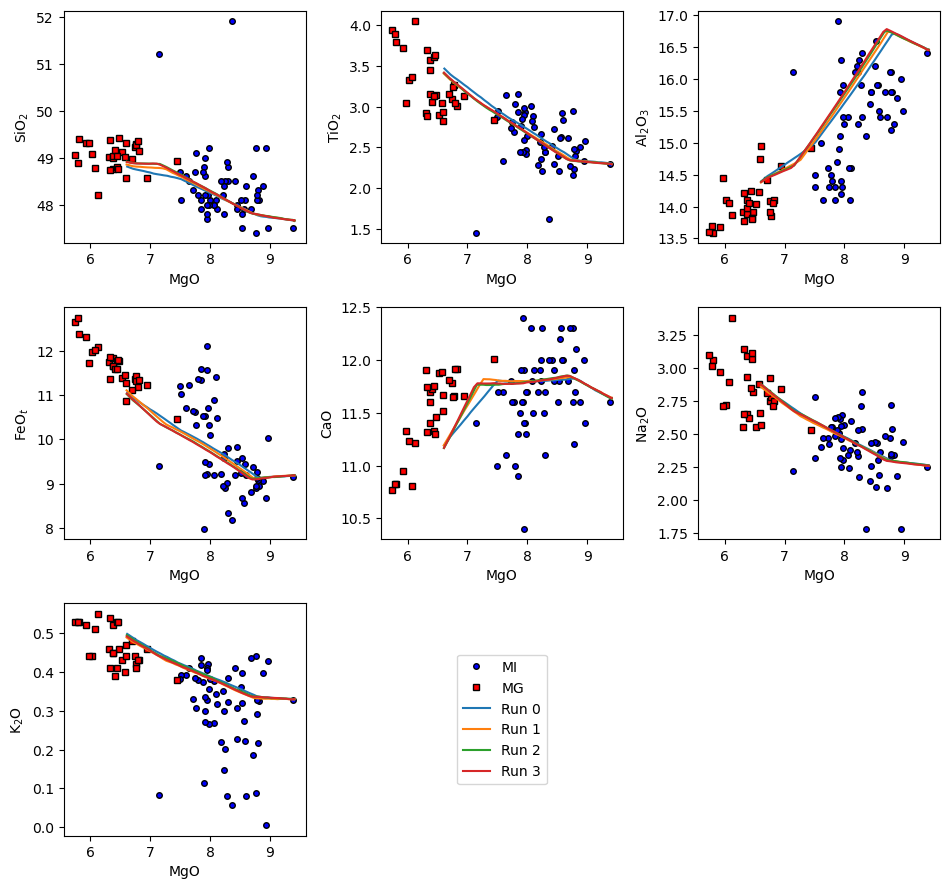

In [8]:
ptt.harker(Results = Polybaric_Xtal,   data = {'MI': MI, 'MG': MG},
    d_color = ['b','red'], legend_loc = [1,2])